<a href="https://colab.research.google.com/github/Robin69latrik/Deeplearning/blob/main/2_0_GAN_fashion_mnist_CPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Generative Adversarial Network (GAN)
GANs are a form of neural network in which two sub-networks (the encoder and decoder) are trained on opposing loss functions: an encoder that is trained to produce data which is indiscernable from the true data, and a decoder that is trained to discern between the data and generated data.

![gan](https://github.com/timsainb/tensorflow2-generative-models/blob/master/imgs/gan.png?raw=1)

### Install packages if in colab

In [1]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

### load packages

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/tmp/ipython-input-2963061230.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
print(tf.__version__)

2.19.0


### Create a fashion-MNIST dataset

In [4]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [5]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Define the network as tf.keras.model object

In [6]:
class GAN(tf.keras.Model):
    """ a basic GAN class
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)


def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


### Define the network architecture

In [7]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Create Model

In [8]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

### Train the model

In [9]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, 1, 1, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [10]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 49 | disc_loss: 0.7230979204177856 | gen_loss: 1.6509078741073608


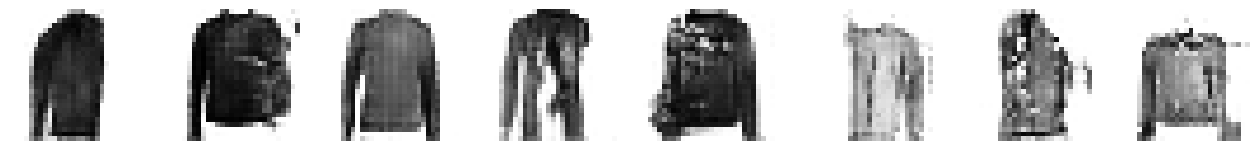

In [11]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)

In [ ]:
loss.append(model.compute_loss(train_x))

for batch, test_x in tqdm(
    zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
):
    loss.append(model.compute_loss(test_x))  # utilisation correcte des images de test

def plot_comparison(model, real_images, n_samples=8):
    fake_images = model.generate(tf.random.normal(shape=(n_samples, 1, 1, N_Z)))
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*2, 4))
    for i in range(n_samples):
        axes[0, i].imshow(real_images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(fake_images[i].numpy().squeeze(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle(f"Époque {epoch} : images réelles (haut) vs générées (bas)")
    plt.show()

def plot_losses(losses):
    plt.figure(figsize=(8,5))
    plt.plot(losses.index, losses['disc_loss'], label='Discriminateur')
    plt.plot(losses.index, losses['gen_loss'], label='Générateur')
    plt.xlabel("Époque")
    plt.ylabel("Loss")
    plt.title("Évolution des losses au cours de l'entraînement")
    plt.legend()
    plt.grid(True)
    plt.show()


# Sélection d’un batch d’images réelles pour la comparaison
for real_batch in train_dataset.take(1):
    real_images = real_batch.numpy()

n_epochs = 50
for epoch in range(n_epochs):
    # Entraînement sur le dataset
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)

    # Évaluation sur le dataset test
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    # Affichage des résultats
    print(
        "Époque: {} | disc_loss: {:.4f} | gen_loss: {:.4f}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_comparison(model, real_images)  # comparaison images réelles vs générées
    plot_losses(losses)  # évolution des losses



## GAN sur CIFAR-10

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# --- Paramètres ---
BATCH_SIZE = 512
N_Z = 64       # taille du vecteur de bruit
N_EPOCHS = 50

# --- Charger CIFAR-10 ---
(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()

# Normalisation [0,1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Batching
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(50000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(10000).batch(BATCH_SIZE)

# --- Architecture GAN adaptée CIFAR-10 ---
DIMS = (32,32,3)

# Générateur
generator = [
    tf.keras.layers.Input(shape=(N_Z,)),  # vecteur de bruit plat
    tf.keras.layers.Dense(units=8*8*128, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(8,8,128)),
    tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(2,2), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(1,1), padding="SAME", activation="relu"),
    tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1,1), padding="SAME", activation="sigmoid")
]

# Discriminateur
discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation="relu"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2), activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None)
]

# --- GAN Class ---
class GAN(tf.keras.Model):
    def __init__(self, gen, disc, gen_optimizer, disc_optimizer, n_Z):
        super(GAN, self).__init__()
        self.gen = tf.keras.Sequential(gen)
        self.disc = tf.keras.Sequential(disc)
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.n_Z = n_Z

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        z_samp = tf.random.normal([x.shape[0], self.n_Z])  # vecteur plat
        x_gen = self.generate(z_samp)
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        disc_real_loss = gan_loss(logits_x, is_real=True)
        disc_fake_loss = gan_loss(logits_x_gen, is_real=False)
        disc_loss = disc_real_loss + disc_fake_loss
        gen_loss = gan_loss(logits_x_gen, is_real=True)
        return disc_loss, gen_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

# --- Fonction perte ---
def gan_loss(logits, is_real=True):
    labels = tf.ones_like(logits) if is_real else tf.zeros_like(logits)
    return tf.compat.v1.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=logits)

# --- Optimizers ---
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)

# --- Création du modèle ---
model = GAN(
    gen=generator,
    disc=discriminator,
    gen_optimizer=gen_optimizer,
    disc_optimizer=disc_optimizer,
    n_Z=N_Z
)

# --- Fonctions d'affichage ---
def plot_comparison(model, real_images, n_samples=8):
    fake_images = model.generate(tf.random.normal(shape=(n_samples, N_Z)))
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples*2,4))
    for i in range(n_samples):
        axes[0,i].imshow(real_images[i])
        axes[0,i].axis('off')
        axes[1,i].imshow(fake_images[i].numpy())
        axes[1,i].axis('off')
    plt.suptitle(f"Images réelles (haut) vs générées (bas)")
    plt.show()

losses = pd.DataFrame(columns=['disc_loss','gen_loss'])

# Sélection d'un batch d'images réelles pour comparaison
for real_batch in train_dataset.take(1):
    real_images = real_batch.numpy()

# --- Entraînement ---
for epoch in range(N_EPOCHS):
    # Train
    for batch, train_x in tqdm(zip(range(len(train_dataset)), train_dataset), total=len(train_dataset)):
        model.train(train_x)

    # Test
    loss = []
    for batch, test_x in tqdm(zip(range(len(test_dataset)), test_dataset), total=len(test_dataset)):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)

    print(f"Époque: {epoch} | disc_loss: {losses.disc_loss.values[-1]:.4f} | gen_loss: {losses.gen_loss.values[-1]:.4f}")
    plot_comparison(model, real_images)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  0%|          | 0/98 [00:00<?, ?it/s]

ValueError: in user code:

    File "/tmp/ipython-input-2462465064.py", line 88, in train  *
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
    File "/tmp/ipython-input-2462465064.py", line 77, in compute_gradients  *
        disc_loss, gen_loss = self.compute_loss(x)
    File "/tmp/ipython-input-2462465064.py", line 67, in compute_loss  *
        logits_x_gen = self.discriminate(x_gen)
    File "/tmp/ipython-input-2462465064.py", line 61, in discriminate  *
        return self.disc(x)
    File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/input_spec.py", line 227, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling Sequential.call().
    
    [1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 6272, but received input with shape (512, 1152)[0m
    
    Arguments received by Sequential.call():
      • inputs=tf.Tensor(shape=(512, 16, 16, 3), dtype=float32)
      • training=None
      • mask=None
      • kwargs=<class 'inspect._empty'>
